**UNIVERSIDADE DE SÃO PAULO**<br>
**MBA DATA SCIENCE & ANALYTICS USP/ESALQ**<br>
**BIG DATA E DEPLOYMENT DE MODELOS**<br>
**Prof. Helder Prado Santos**<br>
Aluna: Luiza Batista Laquini<br>
Turma: DSA 241<br>

*coding: utf-8*

In [ ]:
# # Instalação dos pacotes necessário
# !pip install pyspark==3.5.1
# !pip install findspark
# !pip install seaborn
# !pip install pandas
# !pip install matplotlib

In [1]:
# Importando as bibliotecas que utilizaremos durante a aula
from pyspark import SparkConf
from pyspark.sql import SparkSession
import findspark
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Encontrando as configurações para inicializar o Spark
findspark.init()

# Nome da aplicação Spark
app_name = "Aplicação Spark"  

# Inicializando o objeto de configurações do Spark
conf = SparkConf()

# Configuração do tipo de cluster
conf.set("spark.master", "local[*]") # cria um cluster local usando todos os núcleos de CPU (especificado com *) - criado com a máquina java
# Definição do nome da aplicação
conf.set("spark.app.name", app_name)
# Definição da quantidade de núcleos de processamento a serem usados
conf.set("spark.executor.cores", "2")
# Definição da quantidade de memória alocada para cada executor
conf.set("spark.executor.memory", "2g")
conf.set("spark.driver.memory", "2g")

# Criando a sessão Spark
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print("Spark inicializado com sucesso!")

Spark inicializado com sucesso!


Visualizar em http://localhost:4040/

In [4]:
###############################################################################
#                              DATA WRANGLING                                 #
###############################################################################

# FONTE: https://www.kaggle.com/data/yuanyuwendymu/airline-delay-and-cance
# llation-data-2009-2018

# Lendo um DataFrame Spark a partir de um arquivo CSV
df = spark.read.csv("./data/2016.csv", header=True, inferSchema=True) # inferSchema = inferência de esquema (diferenciação de float,int,string) - colocar True deixa mais lento

# Exibindo os dados do DataFrame
df.show()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

In [5]:
# Exibindo uma linha do DataFrame em formato vertical
df.show(1, vertical=True)

-RECORD 0-------------------------
 FL_DATE             | 2016-01-01 
 OP_CARRIER          | DL         
 OP_CARRIER_FL_NUM   | 1248       
 ORIGIN              | DTW        
 DEST                | LAX        
 CRS_DEP_TIME        | 1935       
 DEP_TIME            | 1935.0     
 DEP_DELAY           | 0.0        
 TAXI_OUT            | 23.0       
 WHEELS_OFF          | 1958.0     
 WHEELS_ON           | 2107.0     
 TAXI_IN             | 13.0       
 CRS_ARR_TIME        | 2144       
 ARR_TIME            | 2120.0     
 ARR_DELAY           | -24.0      
 CANCELLED           | 0.0        
 CANCELLATION_CODE   | NULL       
 DIVERTED            | 0.0        
 CRS_ELAPSED_TIME    | 309.0      
 ACTUAL_ELAPSED_TIME | 285.0      
 AIR_TIME            | 249.0      
 DISTANCE            | 1979.0     
 CARRIER_DELAY       | NULL       
 WEATHER_DELAY       | NULL       
 NAS_DELAY           | NULL       
 SECURITY_DELAY      | NULL       
 LATE_AIRCRAFT_DELAY | NULL       
 Unnamed: 27        

In [6]:
# Exibindo o esquema do DataFrame (nome das colunas e tipos)
df.printSchema()

# FL_DATE                      | DATA_VOO
# OP_CARRIER                   | TRANSPORTADORA
# OP_CARRIER_FL_NUM            | NUM_VOO_TRANSPORTADORA
# ORIGIN                       | ORIGEM
# DEST                         | DESTINO
# CRS_DEP_TIME                 | HORARIO_PARTIDA_PROGRAMADO
# DEP_TIME                     | HORARIO_PARTIDA_REAL
# DEP_DELAY                    | ATRASO_PARTIDA
# TAXI_OUT                     | TAXI_OUT
# WHEELS_OFF                   | HORARIO_DECOLAGEM
# WHEELS_ON                    | HORARIO_POUSO
# TAXI_IN                      | TAXI_IN
# CRS_ARR_TIME                 | HORARIO_CHEGADA_PROGRAMADO
# ARR_TIME                     | HORARIO_CHEGADA_REAL
# ARR_DELAY                    | ATRASO_CHEGADA (em mins)
# CANCELLED                    | CANCELADO
# CANCELLATION_CODE            | CODIGO_CANCELAMENTO
# DIVERTED                     | DESVIADO
# CRS_ELAPSED_TIME             | TEMPO_DE_VOO_PROGRAMADO
# ACTUAL_ELAPSED_TIME          | TEMPO_DE_VOO_REAL (em mins)
# AIR_TIME                     | TEMPO_DE_VOO_EM_AR
# DISTANCE                     | DISTANCIA
# CARRIER_DELAY                | ATRASO_DA_TRANSPORTADORA
# WEATHER_DELAY                | ATRASO_DE_CLIMA
# NAS_DELAY                    | ATRASO_NAS
# SECURITY_DELAY               | ATRASO_DE_SEGURANCA
# LATE_AIRCRAFT_DELAY          | ATRASO_DE_AERONAVE_TARDE

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

In [7]:
# Criando um DataFrame com colunas selecionadas
df_selecionado = df.select(["DISTANCE", "ACTUAL_ELAPSED_TIME", "ARR_DELAY"])

# Exibindo o DataFrame com as colunas selecionadas
df_selecionado.show()

+--------+-------------------+---------+
|DISTANCE|ACTUAL_ELAPSED_TIME|ARR_DELAY|
+--------+-------------------+---------+
|  1979.0|              285.0|    -24.0|
|   640.0|              109.0|     -2.0|
|  1947.0|              231.0|    -13.0|
|  1590.0|              193.0|    -16.0|
|   874.0|              188.0|    124.0|
|   214.0|               66.0|     83.0|
|   214.0|               58.0|     74.0|
|   270.0|               67.0|      3.0|
|   270.0|               63.0|    -15.0|
|   761.0|              137.0|    -12.0|
|  1517.0|              203.0|    -33.0|
|  2475.0|              313.0|    -14.0|
|   620.0|              102.0|    -11.0|
|   620.0|              127.0|    -15.0|
|  1990.0|              272.0|      6.0|
|   214.0|               62.0|    -18.0|
|   712.0|              157.0|      6.0|
|  1096.0|              186.0|    -26.0|
|   271.0|               65.0|    -10.0|
|   271.0|               57.0|    -20.0|
+--------+-------------------+---------+
only showing top

In [8]:

# Visualizando as análises univariadas
df_selecionado.describe().show()

+-------+-----------------+-------------------+------------------+
|summary|         DISTANCE|ACTUAL_ELAPSED_TIME|         ARR_DELAY|
+-------+-----------------+-------------------+------------------+
|  count|          5617658|            5538145|           5538145|
|   mean|850.0785813233914| 140.16078867563056|3.5192899427515894|
| stddev|619.5001373392867|  75.66282676521739| 41.87331683749171|
|    min|             25.0|               14.0|            -152.0|
|    max|           4983.0|              778.0|            2142.0|
+-------+-----------------+-------------------+------------------+



In [9]:
# Contagem de linhas do dataset
total_linhas = df.count()

print(f"Total de linhas no dataset: {total_linhas} \n")

Total de linhas no dataset: 5617658 



O método count pode ser muito demorado dependendo da base de dados. Assim, um método muito utilizado é fazer o count de uma pequena amostra e depois estimar para o tamanho do dataset inteiro. Veja a seguir:

In [10]:
# Verificando o número de partições utilizadas no processamento distribuído
df.rdd.getNumPartitions()

12

In [12]:
# Coletando uma pequena amostra equivalente a 1%
pequena_amostra = df.sample(fraction=0.01)

# Contagem de linhas do dataset reduzido
total_linhas_pequena_amostra = pequena_amostra.count()

print(f"Total de linhas no dataset: {total_linhas_pequena_amostra} \n")

Total de linhas no dataset: 56214 



In [13]:
# Estratégia da extrapolação para calcular grandes volumes de dados
total_linhas_extrapoladas = int(total_linhas_pequena_amostra / 0.01)

print(f"Total de linhas no dataset: {total_linhas_extrapoladas} \n")

Total de linhas no dataset: 5621400 



In [15]:
# Tratando dados temporais

#  Importando funções úteis do PySpark para tratamento de dados
import pyspark.sql.functions as F

# Documentação: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html

# Extraindo o ano da variável FL_DATE
df = df.withColumn("ano", F.year(df["FL_DATE"]))

# Extraindo o mês da variável FL_DATE
df = df.withColumn("mes", F.month(df["FL_DATE"]))

# Extraindo o dia do mês da variável FL_DATE
df = df.withColumn("dia", F.dayofmonth(df["FL_DATE"]))

# Exibindo os dados com as novas colunas
df.show(5, vertical=True)

-RECORD 0-------------------------
 FL_DATE             | 2016-01-01 
 OP_CARRIER          | DL         
 OP_CARRIER_FL_NUM   | 1248       
 ORIGIN              | DTW        
 DEST                | LAX        
 CRS_DEP_TIME        | 1935       
 DEP_TIME            | 1935.0     
 DEP_DELAY           | 0.0        
 TAXI_OUT            | 23.0       
 WHEELS_OFF          | 1958.0     
 WHEELS_ON           | 2107.0     
 TAXI_IN             | 13.0       
 CRS_ARR_TIME        | 2144       
 ARR_TIME            | 2120.0     
 ARR_DELAY           | -24.0      
 CANCELLED           | 0.0        
 CANCELLATION_CODE   | NULL       
 DIVERTED            | 0.0        
 CRS_ELAPSED_TIME    | 309.0      
 ACTUAL_ELAPSED_TIME | 285.0      
 AIR_TIME            | 249.0      
 DISTANCE            | 1979.0     
 CARRIER_DELAY       | NULL       
 WEATHER_DELAY       | NULL       
 NAS_DELAY           | NULL       
 SECURITY_DELAY      | NULL       
 LATE_AIRCRAFT_DELAY | NULL       
 Unnamed: 27        

In [16]:
# Removendo colunas indesejadas com o método drop
df = df.drop("Unnamed: 27")

# Exibindo os dados após a exclusão da coluna
df.show(5, vertical=True)

-RECORD 0-------------------------
 FL_DATE             | 2016-01-01 
 OP_CARRIER          | DL         
 OP_CARRIER_FL_NUM   | 1248       
 ORIGIN              | DTW        
 DEST                | LAX        
 CRS_DEP_TIME        | 1935       
 DEP_TIME            | 1935.0     
 DEP_DELAY           | 0.0        
 TAXI_OUT            | 23.0       
 WHEELS_OFF          | 1958.0     
 WHEELS_ON           | 2107.0     
 TAXI_IN             | 13.0       
 CRS_ARR_TIME        | 2144       
 ARR_TIME            | 2120.0     
 ARR_DELAY           | -24.0      
 CANCELLED           | 0.0        
 CANCELLATION_CODE   | NULL       
 DIVERTED            | 0.0        
 CRS_ELAPSED_TIME    | 309.0      
 ACTUAL_ELAPSED_TIME | 285.0      
 AIR_TIME            | 249.0      
 DISTANCE            | 1979.0     
 CARRIER_DELAY       | NULL       
 WEATHER_DELAY       | NULL       
 NAS_DELAY           | NULL       
 SECURITY_DELAY      | NULL       
 LATE_AIRCRAFT_DELAY | NULL       
 ano                

In [17]:
# Selecionando apenas as colunas temporais
df.select("FL_DATE", "ano", "mes", "dia").show()

# Verificando novamente o esquema dos dados
df.printSchema()

+----------+----+---+---+
|   FL_DATE| ano|mes|dia|
+----------+----+---+---+
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
|2016-01-01|2016|  1|  1|
+----------+----+---+---+
only showing top 20 rows

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: d

In [18]:
# Verificando valores nulos no dataset
# Lógica: contagem quando cada linha da coluna é um valor nulo
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show(
    vertical=True
)

-RECORD 0----------------------
 FL_DATE             | 0       
 OP_CARRIER          | 0       
 OP_CARRIER_FL_NUM   | 0       
 ORIGIN              | 0       
 DEST                | 0       
 CRS_DEP_TIME        | 0       
 DEP_TIME            | 63456   
 DEP_DELAY           | 63456   
 TAXI_OUT            | 65418   
 WHEELS_OFF          | 65418   
 WHEELS_ON           | 67844   
 TAXI_IN             | 67844   
 CRS_ARR_TIME        | 0       
 ARR_TIME            | 67844   
 ARR_DELAY           | 79513   
 CANCELLED           | 0       
 CANCELLATION_CODE   | 5551797 
 DIVERTED            | 0       
 CRS_ELAPSED_TIME    | 6       
 ACTUAL_ELAPSED_TIME | 79513   
 AIR_TIME            | 79513   
 DISTANCE            | 0       
 CARRIER_DELAY       | 4653419 
 WEATHER_DELAY       | 4653419 
 NAS_DELAY           | 4653419 
 SECURITY_DELAY      | 4653419 
 LATE_AIRCRAFT_DELAY | 4653419 
 ano                 | 0       
 mes                 | 0       
 dia                 | 0       



In [20]:
# Carregando os dados das transportadoras
df_transportadoras = spark.read.csv(
    "./data/transportadoras.csv", header=True
)

# Visualizando as lindas e colunas do dataset
df_transportadoras.show(truncate=False)

+---------+---------+---------------------------+
|IATA Code|ICAO Code|Air Carrier Name           |
+---------+---------+---------------------------+
|ZW       |AWI      |Air Wisconsin              |
|AS       |ASA      |Alaska Airlines            |
|G4       |AAY      |Allegiant Air LLC          |
|AA       |AAL      |American Airlines          |
|C5       |UCA      |Champlain Air              |
|CP       |CPZ      |Compass Airlines           |
|DL       |DAL      |Delta Air Lines            |
|EM       |CFS      |Empire Airline             |
|9E       |EDV      |Endeavor Air               |
|MQ       |ENY      |Envoy Air                  |
|EV       |ASQ      |ExpressJet Airlines        |
|F9       |FFT      |Frontier Airlines          |
|G7       |GJS      |GoJet Airlines             |
|HA       |HAL      |Hawaiian Airlines          |
|QX       |QXE      |Horizon Air                |
|B6       |JBU      |Jetblue Airways Corporation|
|OH       |JIA      |Jetstream Intl             |


In [21]:
# Vamos verificar novamente os dado do nosso banco de dados
df.show(1, vertical=True, truncate=False)

-RECORD 0-------------------------
 FL_DATE             | 2016-01-01 
 OP_CARRIER          | DL         
 OP_CARRIER_FL_NUM   | 1248       
 ORIGIN              | DTW        
 DEST                | LAX        
 CRS_DEP_TIME        | 1935       
 DEP_TIME            | 1935.0     
 DEP_DELAY           | 0.0        
 TAXI_OUT            | 23.0       
 WHEELS_OFF          | 1958.0     
 WHEELS_ON           | 2107.0     
 TAXI_IN             | 13.0       
 CRS_ARR_TIME        | 2144       
 ARR_TIME            | 2120.0     
 ARR_DELAY           | -24.0      
 CANCELLED           | 0.0        
 CANCELLATION_CODE   | NULL       
 DIVERTED            | 0.0        
 CRS_ELAPSED_TIME    | 309.0      
 ACTUAL_ELAPSED_TIME | 285.0      
 AIR_TIME            | 249.0      
 DISTANCE            | 1979.0     
 CARRIER_DELAY       | NULL       
 WEATHER_DELAY       | NULL       
 NAS_DELAY           | NULL       
 SECURITY_DELAY      | NULL       
 LATE_AIRCRAFT_DELAY | NULL       
 ano                

In [22]:
# Renomeando os nomes das colunas para igualar os dados dos dataframes
df_transportadoras = df_transportadoras.withColumnRenamed(
    "IATA Code", "OP_CARRIER"
)

# Verificando novamente o esquema dos dados
df_transportadoras.printSchema()

root
 |-- OP_CARRIER: string (nullable = true)
 |-- ICAO Code: string (nullable = true)
 |-- Air Carrier Name: string (nullable = true)



In [23]:
# Tipos de joins: inner, cross, outer,full, full_outer, left, left_outer,
# right, right_outer,left_semi, and left_anti.

# Unindo o dataframe original com o dataframe das transportados na coluna
# OP_CARRIER no tipo left (A <- B)

df = df.join(df_transportadoras, on="OP_CARRIER", how="left").drop(
    "OP_CARRIER"
)

# Verificando o schema dos dados após o junção
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- NAS_DELAY: doubl

In [24]:
# Verificando os nomes das transportadoras no dataframe original
df.show(vertical=True, truncate=False)

-RECORD 0------------------------------
 FL_DATE             | 2016-01-01      
 OP_CARRIER_FL_NUM   | 1248            
 ORIGIN              | DTW             
 DEST                | LAX             
 CRS_DEP_TIME        | 1935            
 DEP_TIME            | 1935.0          
 DEP_DELAY           | 0.0             
 TAXI_OUT            | 23.0            
 WHEELS_OFF          | 1958.0          
 WHEELS_ON           | 2107.0          
 TAXI_IN             | 13.0            
 CRS_ARR_TIME        | 2144            
 ARR_TIME            | 2120.0          
 ARR_DELAY           | -24.0           
 CANCELLED           | 0.0             
 CANCELLATION_CODE   | NULL            
 DIVERTED            | 0.0             
 CRS_ELAPSED_TIME    | 309.0           
 ACTUAL_ELAPSED_TIME | 285.0           
 AIR_TIME            | 249.0           
 DISTANCE            | 1979.0          
 CARRIER_DELAY       | NULL            
 WEATHER_DELAY       | NULL            
 NAS_DELAY           | NULL            


In [25]:
###############################################################################
#                       AGRUPAMENTO E RESUMO DE DADOS                         #
###############################################################################

# Fluxo de funções: groupby -> agg

# Agrupando por mes e agregando pela média do atraso na chegada
df.groupby("mes").agg(F.avg("ARR_DELAY").alias("media_atraso_chegada")).show()

+---+--------------------+
|mes|media_atraso_chegada|
+---+--------------------+
|  1|   1.533653513286468|
|  2|  0.6652991970622235|
|  3|  3.1459138871633643|
|  4|  0.6968198081024388|
|  5|  2.2490057812950184|
|  6|   7.154742200301092|
|  7|  10.384150586932357|
|  8|   8.013417284908106|
|  9| 0.49918242523610235|
| 10| -0.2230462516524559|
| 11| -1.8610726847860712|
| 12|   8.664734017499983|
+---+--------------------+



In [26]:
# Agrupando e resumindo múltiplas colunas
df_agrupado = df.groupby("mes").agg(
    # média do atraso na chegada
    F.avg("ARR_DELAY").alias("media_atraso_chegada"),
    # soma de voos cancelados
    F.sum("CANCELLED").alias("voos_cancelados"),
    # contagem da quantidade de voos (linhas)
    F.count(F.lit(1)).alias("quantidade_de_voos"),
)

# Visualizar o dataset agrupado
df_agrupado.show()

+---+--------------------+---------------+------------------+
|mes|media_atraso_chegada|voos_cancelados|quantidade_de_voos|
+---+--------------------+---------------+------------------+
|  1|   1.533653513286468|        11665.0|            445827|
|  2|  0.6652991970622235|         6823.0|            423889|
|  3|  3.1459138871633643|         4733.0|            479122|
|  4|  0.6968198081024388|         4109.0|            461630|
|  5|  2.2490057812950184|         2509.0|            479358|
|  6|   7.154742200301092|         4982.0|            487637|
|  7|  10.384150586932357|         9309.0|            502457|
|  8|   8.013417284908106|         6893.0|            498347|
|  9| 0.49918242523610235|         1517.0|            454878|
| 10| -0.2230462516524559|         4547.0|            472626|
| 11| -1.8610726847860712|         1310.0|            450938|
| 12|   8.664734017499983|         7464.0|            460949|
+---+--------------------+---------------+------------------+



In [27]:
# Criando uma nova coluna com a porcentagem dos voos
df_agrupado = df_agrupado.withColumn(
    "porcentagem_voos_cancelados",
    # fórmula: (voos_cancelados/quantidade_de_voos)*100
    (df_agrupado["voos_cancelados"] / df_agrupado["quantidade_de_voos"]) * 100,
)

# Visualizar o dataset agrupado
df_agrupado.show()

+---+--------------------+---------------+------------------+---------------------------+
|mes|media_atraso_chegada|voos_cancelados|quantidade_de_voos|porcentagem_voos_cancelados|
+---+--------------------+---------------+------------------+---------------------------+
|  1|   1.533653513286468|        11665.0|            445827|         2.6164857669006136|
|  2|  0.6652991970622235|         6823.0|            423889|           1.60961949944443|
|  3|  3.1459138871633643|         4733.0|            479122|         0.9878486064092236|
|  4|  0.6968198081024388|         4109.0|            461630|          0.890106795485562|
|  5|  2.2490057812950184|         2509.0|            479358|         0.5234083920577105|
|  6|   7.154742200301092|         4982.0|            487637|          1.021661604841306|
|  7|  10.384150586932357|         9309.0|            502457|         1.8526958525804198|
|  8|   8.013417284908106|         6893.0|            498347|         1.3831727691748923|
|  9| 0.49

In [28]:
# Filtrando apenas os dados dos voos cancelados
df_cancelados = df.where(df["CANCELLED"] == 1)

# Mostrando os dados de forma vertical
df_cancelados.show(1, vertical=True)

-RECORD 0------------------------------
 FL_DATE             | 2016-01-01      
 OP_CARRIER_FL_NUM   | 29              
 ORIGIN              | ORD             
 DEST                | SEA             
 CRS_DEP_TIME        | 1530            
 DEP_TIME            | NULL            
 DEP_DELAY           | NULL            
 TAXI_OUT            | NULL            
 WHEELS_OFF          | NULL            
 WHEELS_ON           | NULL            
 TAXI_IN             | NULL            
 CRS_ARR_TIME        | 1815            
 ARR_TIME            | NULL            
 ARR_DELAY           | NULL            
 CANCELLED           | 1.0             
 CANCELLATION_CODE   | A               
 DIVERTED            | 0.0             
 CRS_ELAPSED_TIME    | 285.0           
 ACTUAL_ELAPSED_TIME | NULL            
 AIR_TIME            | NULL            
 DISTANCE            | 1721.0          
 CARRIER_DELAY       | NULL            
 WEATHER_DELAY       | NULL            
 NAS_DELAY           | NULL            


In [ ]:
# Códigos de cancelamento

# A = Por transportadora
# B = Devido às condições climáticas
# C = Pelo sistema nacional de transporte aéreo
# D = Por razões de segurança

In [30]:
# Trocando os dados pelas informações reais
df_cancelados = df_cancelados.withColumn(
    "CANCELLATION_CODE",
    F.when(
        df_cancelados["CANCELLATION_CODE"] == "A", "Por transportadora"
    ).otherwise(df_cancelados["CANCELLATION_CODE"]),
)
df_cancelados = df_cancelados.withColumn(
    "CANCELLATION_CODE",
    F.when(
        df_cancelados["CANCELLATION_CODE"] == "B",
        "Devido às condições climáticas",
    ).otherwise(df_cancelados["CANCELLATION_CODE"]),
)
df_cancelados = df_cancelados.withColumn(
    "CANCELLATION_CODE",
    F.when(
        df_cancelados["CANCELLATION_CODE"] == "C",
        "Pelo sistema nacional de transporte aéreo",
    ).otherwise(df_cancelados["CANCELLATION_CODE"]),
)
df_cancelados = df_cancelados.withColumn(
    "CANCELLATION_CODE",
    F.when(
        df_cancelados["CANCELLATION_CODE"] == "D", "Por razões de segurança"
    ).otherwise(df_cancelados["CANCELLATION_CODE"]),
)

# Verificando os dados alterados
df_cancelados.show(vertical=True)

-RECORD 0-----------------------------------
 FL_DATE             | 2016-01-01           
 OP_CARRIER_FL_NUM   | 29                   
 ORIGIN              | ORD                  
 DEST                | SEA                  
 CRS_DEP_TIME        | 1530                 
 DEP_TIME            | NULL                 
 DEP_DELAY           | NULL                 
 TAXI_OUT            | NULL                 
 WHEELS_OFF          | NULL                 
 WHEELS_ON           | NULL                 
 TAXI_IN             | NULL                 
 CRS_ARR_TIME        | 1815                 
 ARR_TIME            | NULL                 
 ARR_DELAY           | NULL                 
 CANCELLED           | 1.0                  
 CANCELLATION_CODE   | Por transportadora   
 DIVERTED            | 0.0                  
 CRS_ELAPSED_TIME    | 285.0                
 ACTUAL_ELAPSED_TIME | NULL                 
 AIR_TIME            | NULL                 
 DISTANCE            | 1721.0               
 CARRIER_D

In [31]:
# Renomear coluna para melhor entendimento
df_cancelados = df_cancelados.withColumnRenamed(
    "CANCELLATION_CODE", "motivo_cancelamento"
)

# Agrupar os dados por motivo do cancelamento e a quantidade de voos
# relacionados
df_voos_cancelados_codigos = (
    # forma de agrupamento
    df_cancelados.groupby("motivo_cancelamento")
    # forma de resumir os dados
    .count()
    # renomeando a nova coluna criada
    .withColumnRenamed("count", "quantidade")
)

# Visulizar os dados
df_voos_cancelados_codigos.show(truncate=False)

+-----------------------------------------+----------+
|motivo_cancelamento                      |quantidade|
+-----------------------------------------+----------+
|Devido às condições climáticas           |34465     |
|Pelo sistema nacional de transporte aéreo|11091     |
|Por transportadora                       |20279     |
|Por razões de segurança                  |26        |
+-----------------------------------------+----------+



In [33]:
# Passando as informações do cluster Spark para o kernel do python e criando um
# dataframe pandas
pdf_voos_cancelados_codigos = df_voos_cancelados_codigos.toPandas()

# Agora o dataframe pode ser tratado como um dataframe pandas

# Visualizando as primeiras linhas do dataset
pdf_voos_cancelados_codigos.head()

,motivo_cancelamento,quantidade
0,Devido às condições climáticas,34465
1,Pelo sistema nacional de transporte aéreo,11091
2,Por transportadora,20279
3,Por razões de segurança,26


In [34]:
# Visualizando as variáveis univiaradas
pdf_voos_cancelados_codigos.describe()

,quantidade
count,4.000000
mean,16465.250000
std,14579.291166
min,26.000000
25%,8324.750000
50%,15685.000000
75%,23825.500000
max,34465.000000


In [35]:
# Verificando o tipo do dataframe pyspark
print(type(df_voos_cancelados_codigos))

<class 'pyspark.sql.dataframe.DataFrame'>


In [36]:
# Verificando o tipo do dataframe pandas
print(type(pdf_voos_cancelados_codigos))

<class 'pandas.core.frame.DataFrame'>


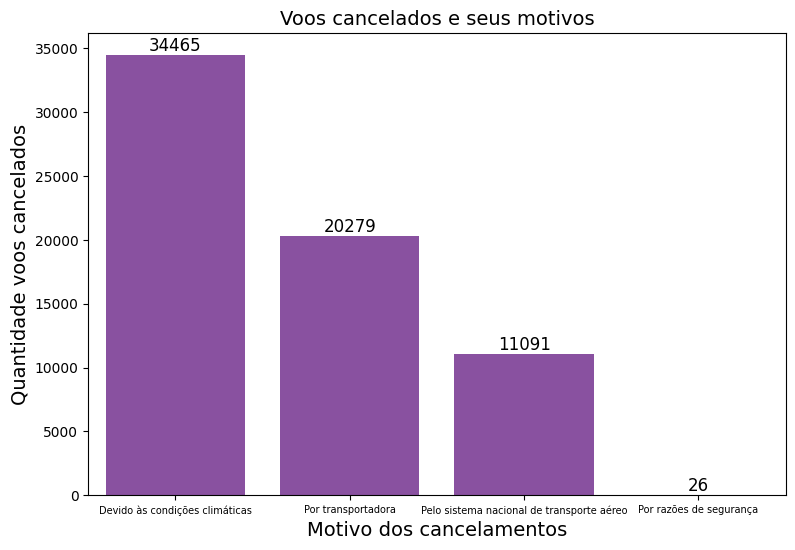

In [57]:
###############################################################################
#                         CRIAÇÃO DE GRÁFICOS                                 #
###############################################################################

# criando um gráfico de barras com os dados retornados

# definindo o tamanho da imagem
plt.figure(figsize=(9,6), dpi=100) 

# criando o gráfico de colunas
ax = sns.barplot(
    pdf_voos_cancelados_codigos.sort_values(by="quantidade", ascending=False),
    x="motivo_cancelamento",
    y="quantidade",
    color="#8e44ad"
)
# alterando título e os rótuos dos eixos x e y
ax.set_ylabel("Quantidade voos cancelados", fontsize=14)
ax.set_xlabel("Motivo dos cancelamentos", fontsize=14)
ax.set_title("Voos cancelados e seus motivos", fontsize=14)
ax.tick_params(axis='x', labelsize=7)

# adicionando os labels nas colunas
ax.bar_label(ax.containers[0], fontsize=12)

# plotar o gráfico
plt.show()

In [46]:
# verificando dados das transportadoras

df_agrupado_companhias = df.groupby("Air Carrier Name").agg(
    # resumir o dado pela média do atraso na chegada e contagem de voos cancelados e total
    # média atraso na chegada
    F.avg("ARR_DELAY").alias("media_atraso"),
    # somatório de voos cancelados
    F.sum("CANCELLED").alias("voos_cancelados"),
    # contagem da quantidade de voos
    F.count(F.lit(1)).alias("quantidade_de_voos"),
)

# mostrar os dados
df_agrupado_companhias.show()

+--------------------+-------------------+---------------+------------------+
|    Air Carrier Name|       media_atraso|voos_cancelados|quantidade_de_voos|
+--------------------+-------------------+---------------+------------------+
|    Skywest Airlines|  4.256732115692655|         8446.0|            605933|
|                NULL|  7.355040508665778|          669.0|             69121|
|     United Airlines| 1.7556160463776733|         5470.0|            545067|
|   Hawaiian Airlines| -0.072610234112839|          118.0|             76789|
| ExpressJet Airlines|  5.439868990877946|        11889.0|            490990|
|   Frontier Airlines|  7.790653787103378|         1179.0|             95121|
|   American Airlines|  5.085088727463136|        10867.0|            914495|
|     Delta Air Lines|-0.5561917600251283|         4116.0|            922746|
|     Alaska Airlines| -2.197627447972593|          815.0|            177280|
|     Spirit Airlines|   9.32820914376048|         2629.0|      

In [47]:
# passando as informações do driver para a memória do kernel e criando um dataframe pandas
pdf_agrupado_companhias = df_agrupado_companhias.toPandas()

# ajustando os dados para organizar os valores pela media do atraso
pdf_agrupado_companhias = pdf_agrupado_companhias.sort_values(
    by="media_atraso", ascending=True
).round(1)

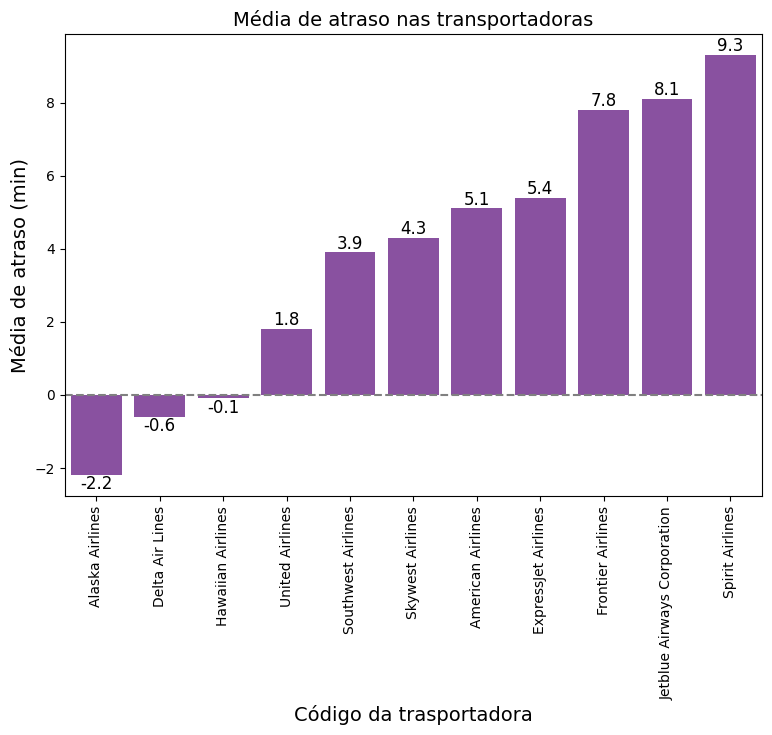

In [48]:
# criando gráfico com os dados retornados

# definindo o tamanho da imagem
plt.figure(figsize=(9, 6), dpi=100)

# criando o gráfico de colunas
ax = sns.barplot(pdf_agrupado_companhias,
                 color="#8e44ad",
                 x="Air Carrier Name", 
                 y="media_atraso")

# alterando título e os rótuos dos eixos x e y
ax.set_ylabel("Média de atraso (min)", fontsize=14)
ax.set_xlabel("Código da trasportadora", fontsize=14)
ax.set_title("Média de atraso nas transportadoras", fontsize=14)

# adicionando os labels nas colunas
ax.bar_label(ax.containers[0], fontsize=12)
ax.tick_params(axis='x', rotation=90)

# adicionar linha auxiliar no eixo y = 0
plt.axhline(y=0, color="gray", linestyle="--")

# plotar o gráfico
plt.show()

In [58]:
###############################################################################
#                    LENDO MÚLTIPLOS DADOS ESTRUTURADOS                       #
###############################################################################

# Coletar a informação do diretório atual#
caminho_atual = os.getcwd()

# Lista de anos para carregar os dados
lista_anos = ["2016", "2017"]

# Lista que vai receber os caminhos completos
caminho_arquivos = []

# Percorrer cada ano da lista de anos
for ano in lista_anos:
    caminho = f"{caminho_atual}/data/{ano}.csv"
    caminho_arquivos.append(caminho)

print(caminho_arquivos)

['c:\\Users\\madeinweb\\Documents\\GitHub\\big-data-e-deployment/data/2016.csv', 'c:\\Users\\madeinweb\\Documents\\GitHub\\big-data-e-deployment/data/2017.csv']


In [59]:
# Criar um dataframe com múltiplas fontes de bases de dados
df = spark.read.csv(caminho_arquivos, header=True, inferSchema=True)

# Contagem de linhas do dataframe criado
df.count()

11292279

In [61]:
# Coletando o ano da variável FL_DATE
df = df.withColumn("ano", F.year(df["FL_DATE"]))

# Coletando o mês da variável FL_DATE
df = df.withColumn("mes", F.month(df["FL_DATE"]))

# Agrupando e resumindo agora os dados por ano
df.groupby("ano").agg(F.avg("ARR_DELAY").alias("media_atraso")).show()

+----+------------------+
| ano|      media_atraso|
+----+------------------+
|2016|3.5192899427515894|
|2017|   4.3263569087054|
+----+------------------+



In [62]:
# Agrupando e resumindo agora os dados por ano e por mês
df.groupby("ano", "mes").agg(
    F.avg("ARR_DELAY").alias("media_atraso")
).orderBy("ano", "mes").show()

+----+---+-------------------+
| ano|mes|       media_atraso|
+----+---+-------------------+
|2016|  1|  1.533653513286468|
|2016|  2| 0.6652991970622235|
|2016|  3| 3.1459138871633643|
|2016|  4| 0.6968198081024388|
|2016|  5| 2.2490057812950184|
|2016|  6|  7.154742200301092|
|2016|  7| 10.384150586932357|
|2016|  8|  8.013417284908106|
|2016|  9|0.49918242523610235|
|2016| 10|-0.2230462516524559|
|2016| 11|-1.8610726847860712|
|2016| 12|  8.664734017499983|
|2017|  1|  6.954483731192212|
|2017|  2| 0.6875590551181102|
|2017|  3|  4.306398360443615|
|2017|  4|  7.322608136076665|
|2017|  5|  6.029889865233924|
|2017|  6|  9.132847670438348|
|2017|  7|  8.295147670495197|
|2017|  8|  6.692594592532966|
+----+---+-------------------+
only showing top 20 rows



In [63]:
# Retirando o dataframe spark da memória e do disco
df.unpersist()

DataFrame[FL_DATE: date, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: int, DEP_TIME: double, DEP_DELAY: double, TAXI_OUT: double, WHEELS_OFF: double, WHEELS_ON: double, TAXI_IN: double, CRS_ARR_TIME: int, ARR_TIME: double, ARR_DELAY: double, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, Unnamed: 27: string, ano: int, mes: int]

In [64]:
# Finalizando a aplicação Spark
spark.stop()

# ############################## FIM DO SCRIPT ################################